# Welcome to an IPython notebook

## Basic Spark functionality in Python

In [1]:
import numpy as np

RDDs

In [2]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
data = sc.parallelize(np.arange(10))
data

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:423

In [4]:
data.first()

0

In [5]:
data.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Map

In [6]:
def square(x):
    return np.square(x)

data.map(square).collect()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [7]:
data.map(lambda x: np.square(x)).collect()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

Filter

In [8]:
data.filter(lambda x: np.mod(x, 2) == 1). collect()

[1, 3, 5, 7, 9]

Reduce

In [9]:
data.reduce(lambda x, y: x+y)

45

## More advanced topics and examples

Loading data

In [10]:
iris = sc.textFile("example-data/series/iris_data.txt")
iris.first()

u'5.1\t3.5\t1.4\t0.2\tsetosa'

Preparing data + key-value pairs

In [11]:
split_iris = iris.map(lambda text: text.split('\t'))
split_iris.first()

[u'5.1', u'3.5', u'1.4', u'0.2', u'setosa']

In [12]:
data = split_iris.map(lambda l: (str(l[-1]), np.array(l[:-1], dtype='float')))
data.first()

('setosa', array([ 5.1,  3.5,  1.4,  0.2]))

Reduce by key

In [13]:
data.mapValues(lambda x: 1).reduceByKey(lambda x, y: x + y).collect()

[('versicolor', 50), ('setosa', 50), ('virginica', 50)]

In [14]:
data.mapValues(lambda x: np.array([x, 1])).reduceByKey(lambda x, y: x + y).mapValues(lambda x: x[0]/x[1]).collect()

[('versicolor', array([ 5.936,  2.77 ,  4.26 ,  1.326])),
 ('setosa', array([ 5.006,  3.428,  1.462,  0.246])),
 ('virginica', array([ 6.588,  2.974,  5.552,  2.026]))]

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

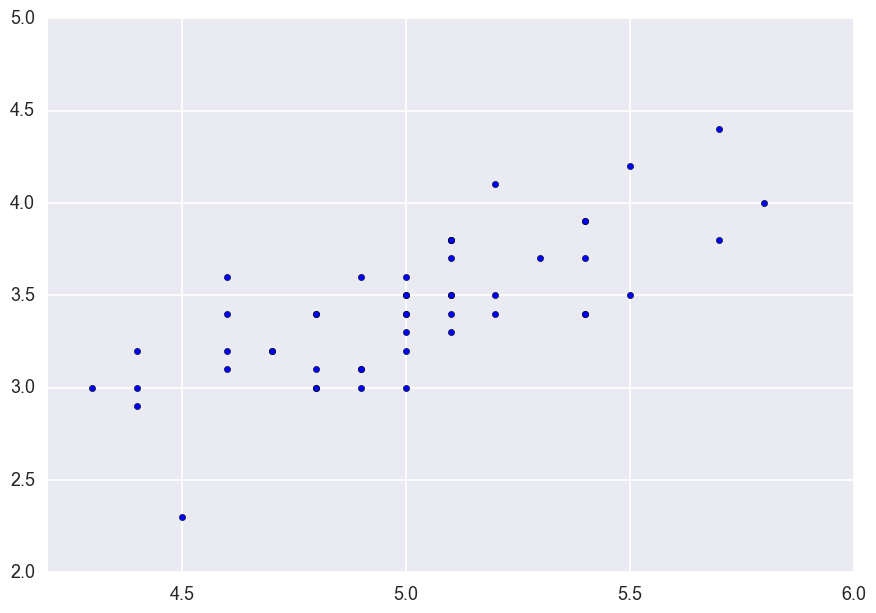

In [22]:
xy = data.filter(lambda (k, v): k == 'setosa').mapValues(lambda x: x[0:2]).values().collect()
xy = np.asarray(xy)

plt.scatter(xy[:,0], xy[:,1]);

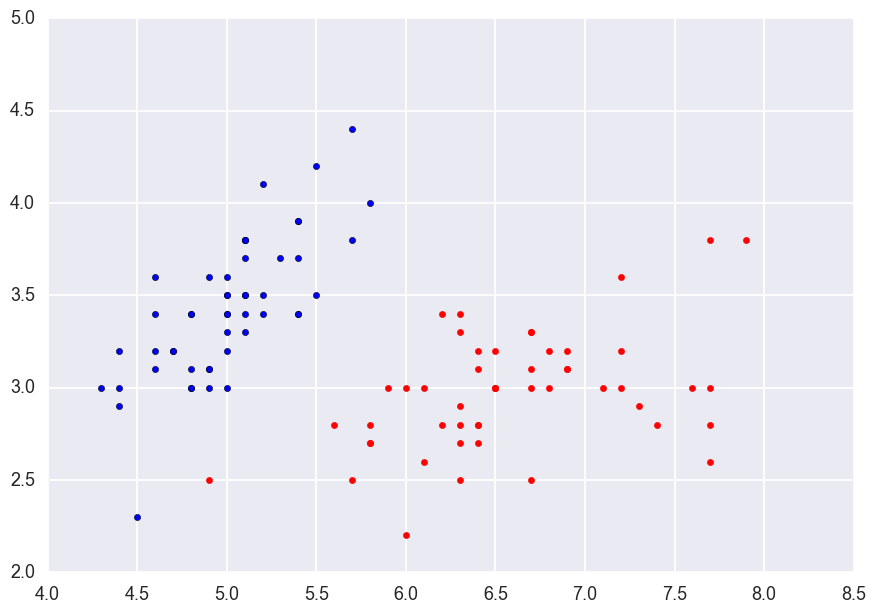

In [23]:
xy1 = data.filter(lambda (k, v): k == 'setosa').mapValues(lambda x: x[0:2]).values().collect()
xy1 = np.asarray(xy1)
xy2 = data.filter(lambda (k, v): k == 'virginica').mapValues(lambda x: x[0:2]).values().collect()
xy2 = np.asarray(xy2)
plt.scatter(xy1[:,0], xy1[:,1]);
plt.scatter(xy2[:,0], xy2[:,1], color='red');

In [24]:
import os 
file_dir = os.path.abspath('example-data/images/flowers')
only_names = [f for f in os.listdir(file_dir)]
filenames = [os.path.join(file_dir, f) for f in only_names]
file_rdd = sc.parallelize(filenames)
file_rdd.take(5)

['/Users/wittenbachj/code/github/spark-janelia/examples/example-data/images/flowers/image_0663.png',
 '/Users/wittenbachj/code/github/spark-janelia/examples/example-data/images/flowers/image_0748.png',
 '/Users/wittenbachj/code/github/spark-janelia/examples/example-data/images/flowers/image_0796.png',
 '/Users/wittenbachj/code/github/spark-janelia/examples/example-data/images/flowers/image_0820.png',
 '/Users/wittenbachj/code/github/spark-janelia/examples/example-data/images/flowers/image_0943.png']

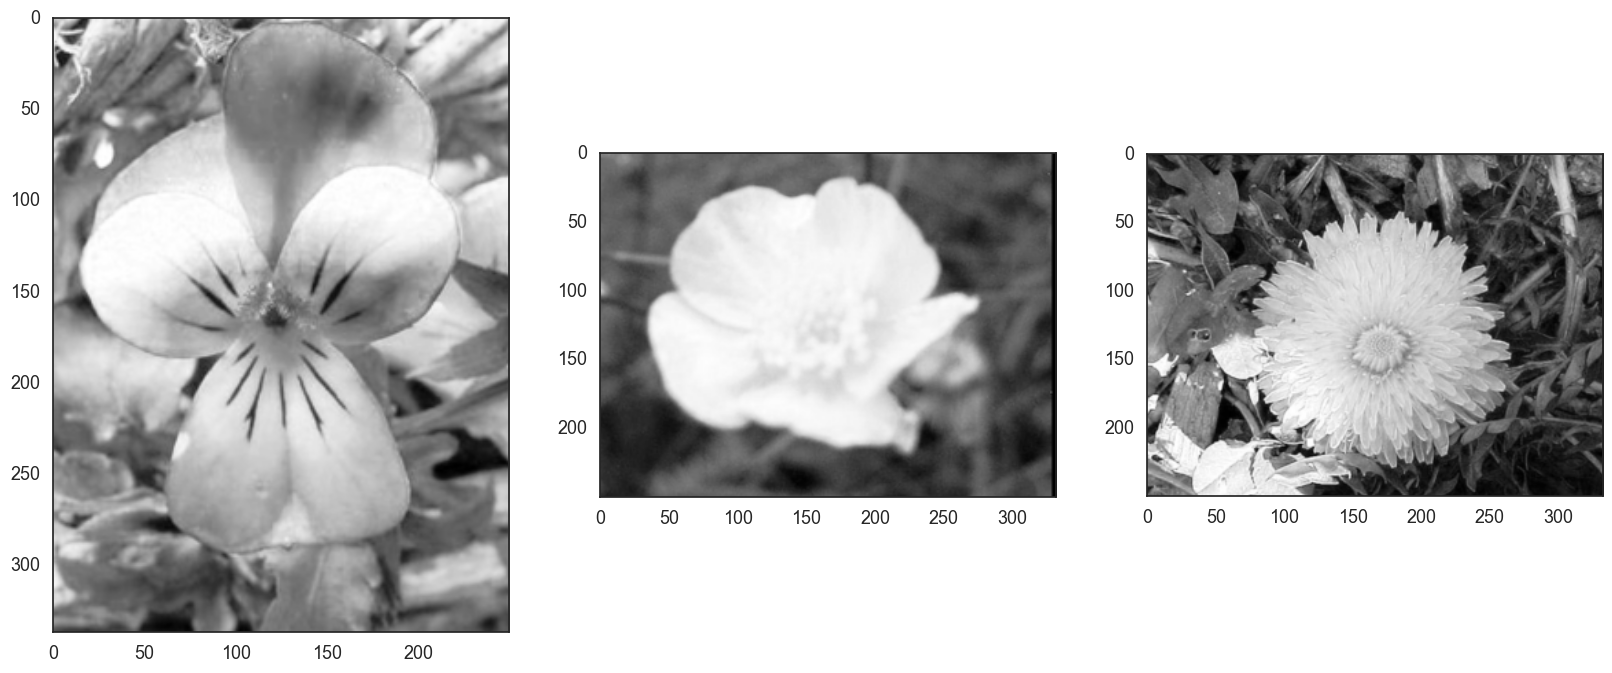

In [30]:
images_rdd = file_rdd.map(lambda f: plt.imread(f))
num_displayed = 3
imgs = images_rdd.takeSample(False, num_displayed)

sns.set_style('white')

def plot_images(n, images): 
    plt.figure(figsize=(20,10))
    for i, img in enumerate(images): 
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        
plot_images(num_displayed, imgs)

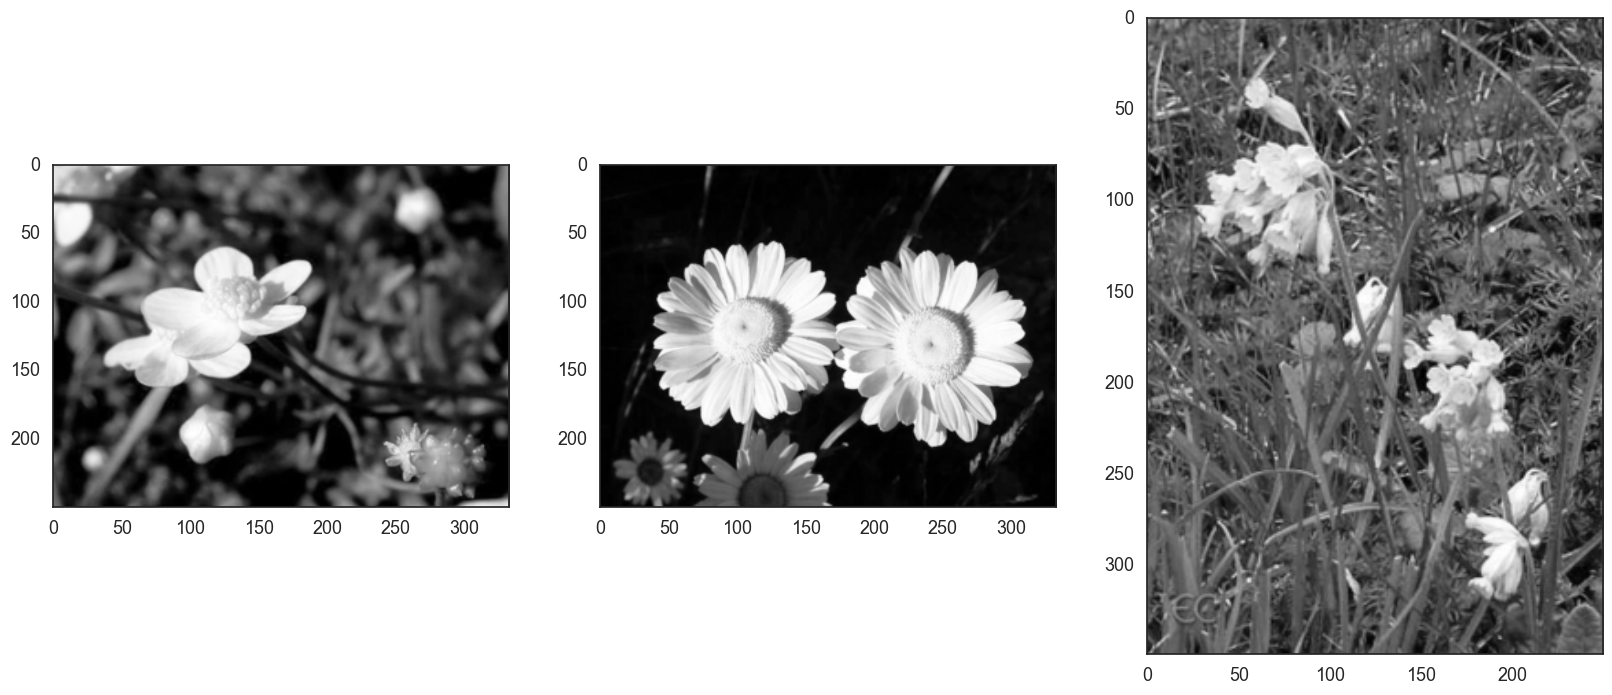

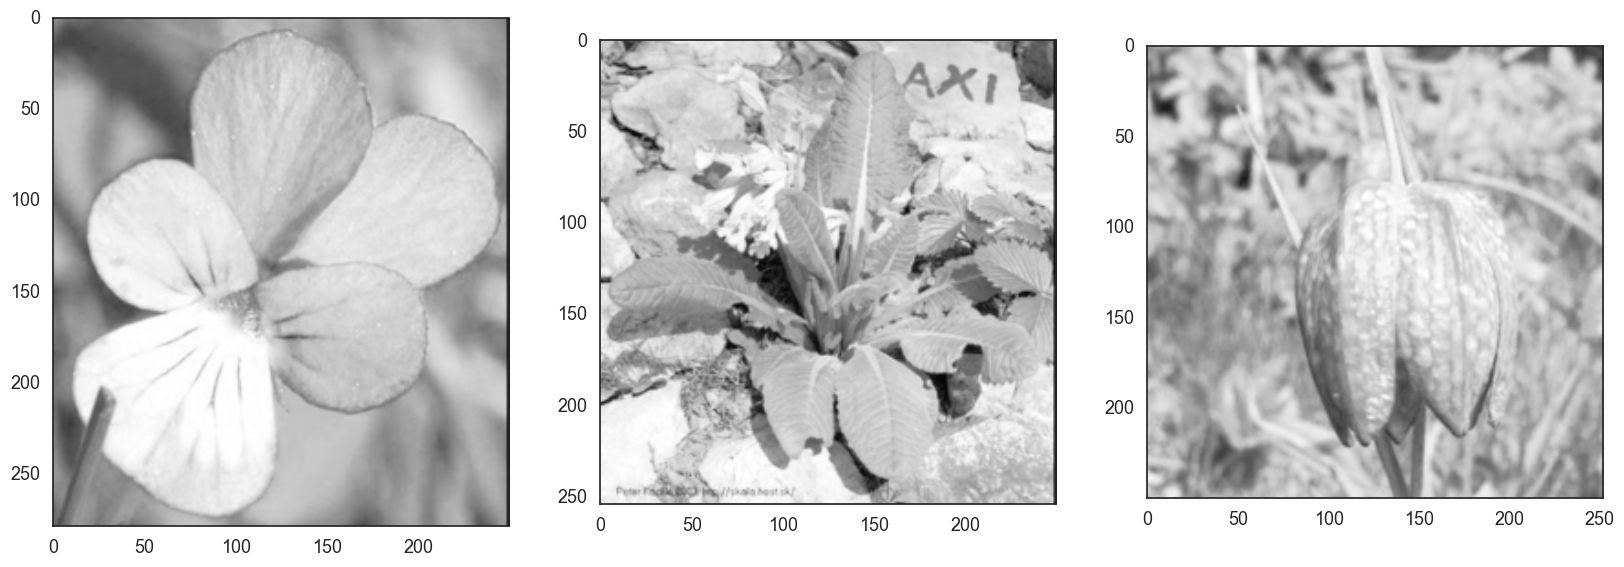

In [44]:
colors_rdd = images_rdd.map(lambda img: (np.mean(img), img))

dark = colors_rdd.sortBy(lambda (k,v): k).values().take(num_displayed)
plot_images(num_displayed, dark)
bright = colors_rdd.sortBy(lambda (k,v): -k).values().take(num_displayed)
plot_images(num_displayed, bright)

## Regression example

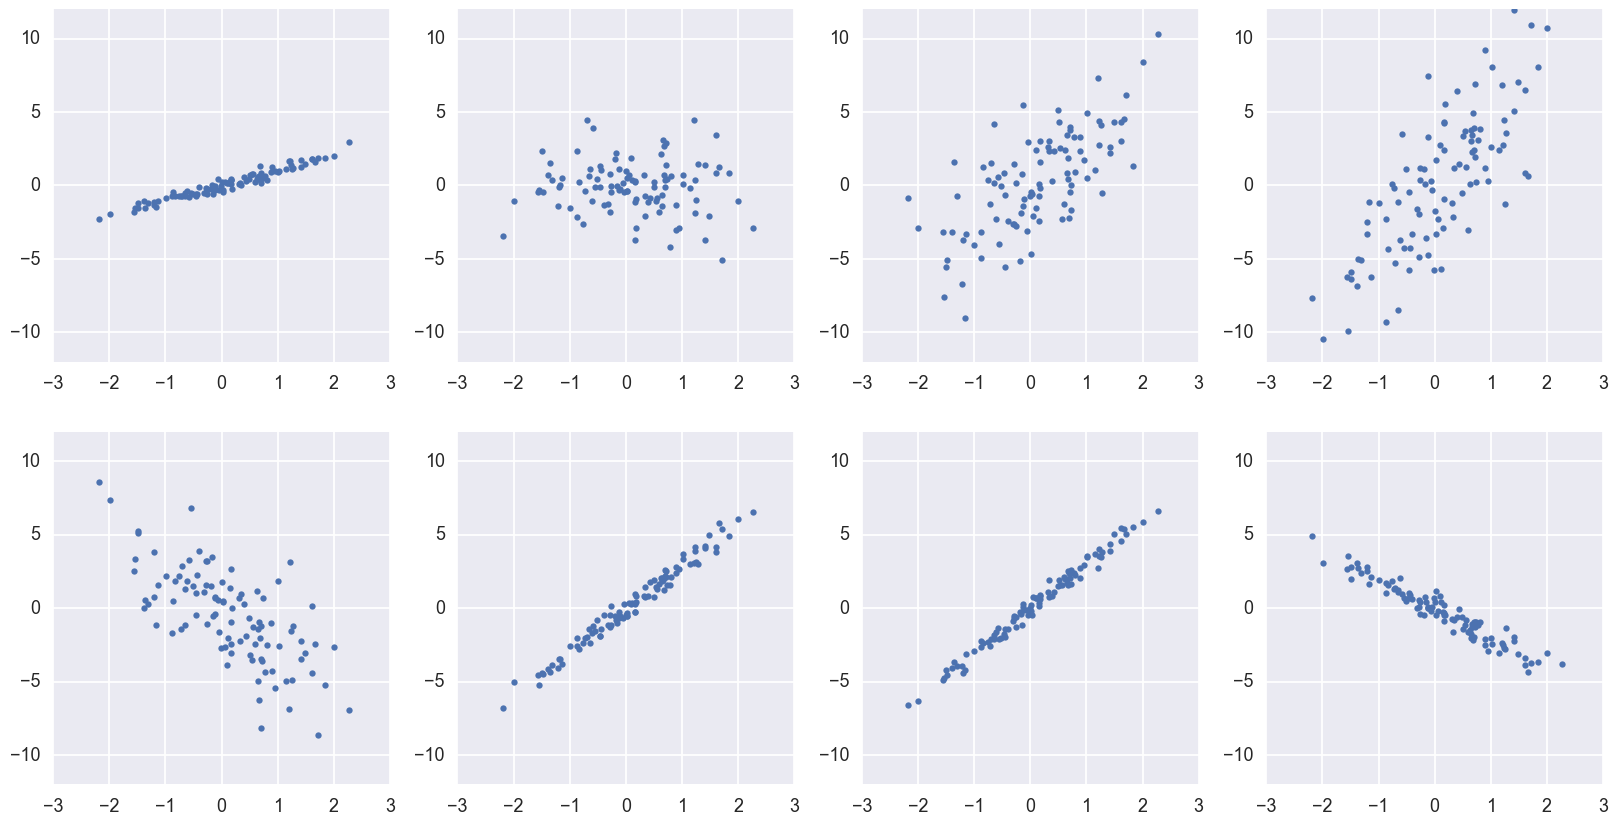

In [46]:
npoints = 100
x = np.random.randn(npoints)

def makeRegressionData(m, noise):
    return m*x + noise*np.random.randn(len(x))

nrecords = 50
y = [(i, makeRegressionData(np.random.uniform(-4, 4), np.random.uniform(0.1, 3))) for i in xrange(npoints)]
data = sc.parallelize(y)

nsamples = 8
sample = data.values().takeSample(False, nsamples)
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
for i in xrange(nsamples):
    plt.subplot(2,4,i+1);
    plt.plot(x, sample[i], '.');
    plt.xlim([-3, 3]);
    plt.ylim([-12, 12]);

In [47]:
from sklearn.linear_model import LinearRegression

def regress(x, y):
    result = LinearRegression().fit(x[None, :].T, y[None, :].T)
    return result.coef_[0,0], result.intercept_[0]

regModels = data.mapValues(lambda y: regress(x, y))

regModels.first()

(0, (-1.0025958120377059, -0.37859075422934668))

In [48]:
joined = data.join(regModels)
joined.first()

(0, (array([-3.73259388, -2.93707117, -0.53988044, -1.10791398,  1.01632694,
         -1.00443668, -1.55571493,  0.07583805, -0.55612974,  2.16702415,
         -2.15305288,  1.95215023,  2.43072439, -0.73640482,  1.68473087,
          0.82917822, -0.91505459,  1.42154826, -2.98219131,  1.71156658,
         -1.45332797,  0.29551806, -0.79423964, -1.45554582, -1.98604252,
         -2.9067046 , -0.07415695,  1.58139448,  2.9180678 ,  0.97013532,
          1.66760822,  2.07293128, -3.23172113,  0.69672905, -3.42410621,
          0.52902112, -2.98319852, -1.05402387,  0.29845582, -1.5154488 ,
         -3.33994004,  6.58734932, -3.63581465,  2.04279063, -7.10185452,
          1.00020756, -3.74147387, -1.2180999 ,  2.15126952, -3.58699222,
          1.76453519, -0.84462067, -4.50953994,  1.17788225, -0.54526157,
         -1.93741254, -2.49814189, -1.52215723, -0.64306402, -4.50670938,
          4.87138332, -1.7666716 , -4.69058921, -5.00819798,  2.45515983,
         -3.47939662, -0.77136192, 

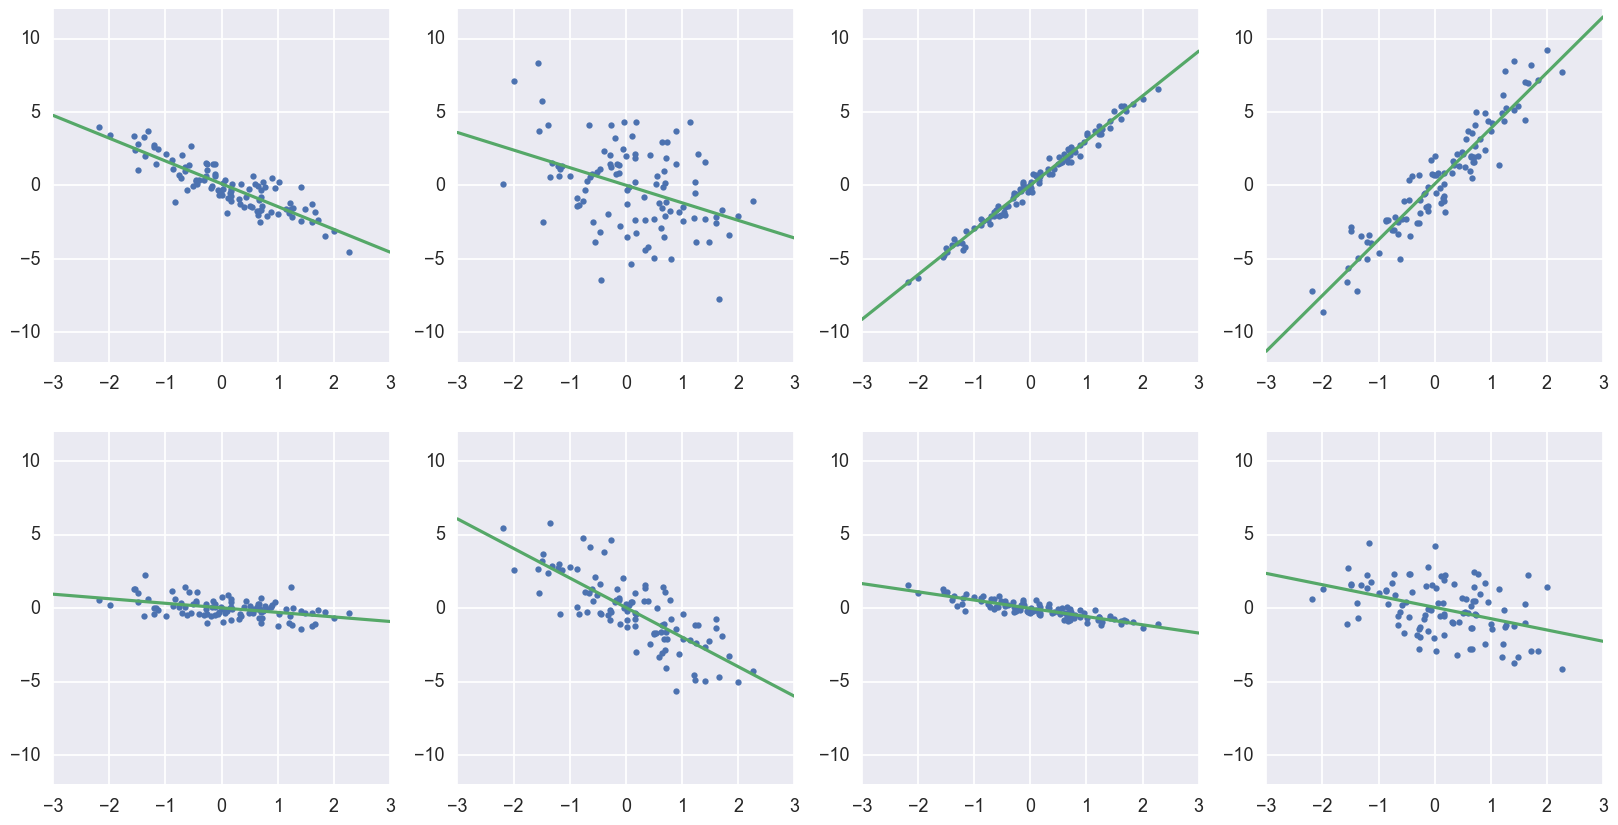

In [50]:
nsamples = 8
sample = joined.values().takeSample(True, nsamples)
xs = np.linspace(-3, 3, 1000)
plt.figure(figsize=(20,10))
for i in xrange(nsamples):
    yvals = sample[i][0]
    m, b = sample[i][1]
    plt.subplot(2,4,i+1);
    plt.plot(x, yvals, '.');
    plt.plot(xs, m*xs + b)
    plt.xlim([-3, 3]);
    plt.ylim([-12, 12]);